In [1]:
library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')

# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/"

zm_leaf_rep_2 <- paste0(analysis_path, "Zm_rep2.merged.unique.mpq10.tn5.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "zm.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.gff3")
chr <- paste0(reference_genome_path,"Zm-B73-REFERENCE-NAM-5.0.chrom.size")
pre <- "zm.Leaf_rep2.QC_v2"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Attaching sp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    '

In [2]:
#Load Object
zm_leaf_rep_2 <- loadBEDandGenomeData(zm_leaf_rep_2, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")


zm_leaf_rep_2.no_organelle <- countRemoveOrganelle(zm_leaf_rep_2, 
                                             org_scaffolds = c("Pt", "Mt"), 
                                             remove_reads = TRUE)

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/zea_mays/Zm_rep2.merged.unique.mpq10.tn5.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/Zm-B73-REFERENCE-NAM-5.0.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data

Identified 413160 organeller reads ...



In [3]:
# call ACRs
zm_temp_dir <- paste0(analysis_path, "zm_peaks.rep2.doover.tmp")
zm_leaf_rep_2.no_organelle <- callACRs(zm_leaf_rep_2.no_organelle, 
                genomesize=1.6e9,
                shift= -50,
                extsize=100,
                fdr=0.05,
                tempdir=zm_temp_dir,
                verbose=T)

zm_leaf_rep_2.meta <- buildMetaData(zm_leaf_rep_2.no_organelle,
                                     tss.window=2000,
                                     verbose=TRUE,
                                     organelle_scaffolds= c("Pt", "Mt"))

 - running MACS2 on bulk BED file ...

 - counting Tn5 sites per barcode ...

 - removing organelle scaffolds from annotation ...

 - counting Tn5 sites at TSSs per barcode ...

 - counting Tn5 sites within ACRs per barcode ...

 - finalizing meta data creation ...

   ~ returning metadata ...




Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




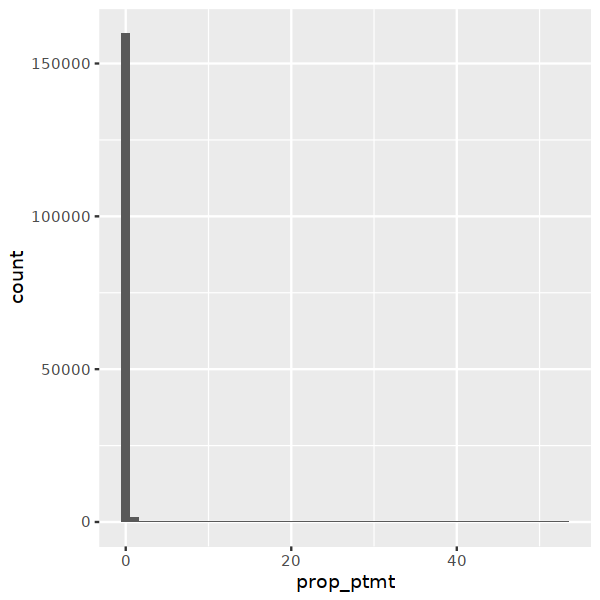

In [4]:

options(repr.plot.width=5, repr.plot.height=5)
library("dplyr")
zm_leaf_rep_2.meta$meta  %>% 
    dplyr::mutate(prop_ptmt = ptmt/total)  %>% 
    ggplot(., aes(prop_ptmt)) + geom_histogram(binwidth = 1)

Warning message:
"package 'repr' was built under R version 4.2.1"
Making Dotplot

... Filtering Cells based of Oragnelle Reads



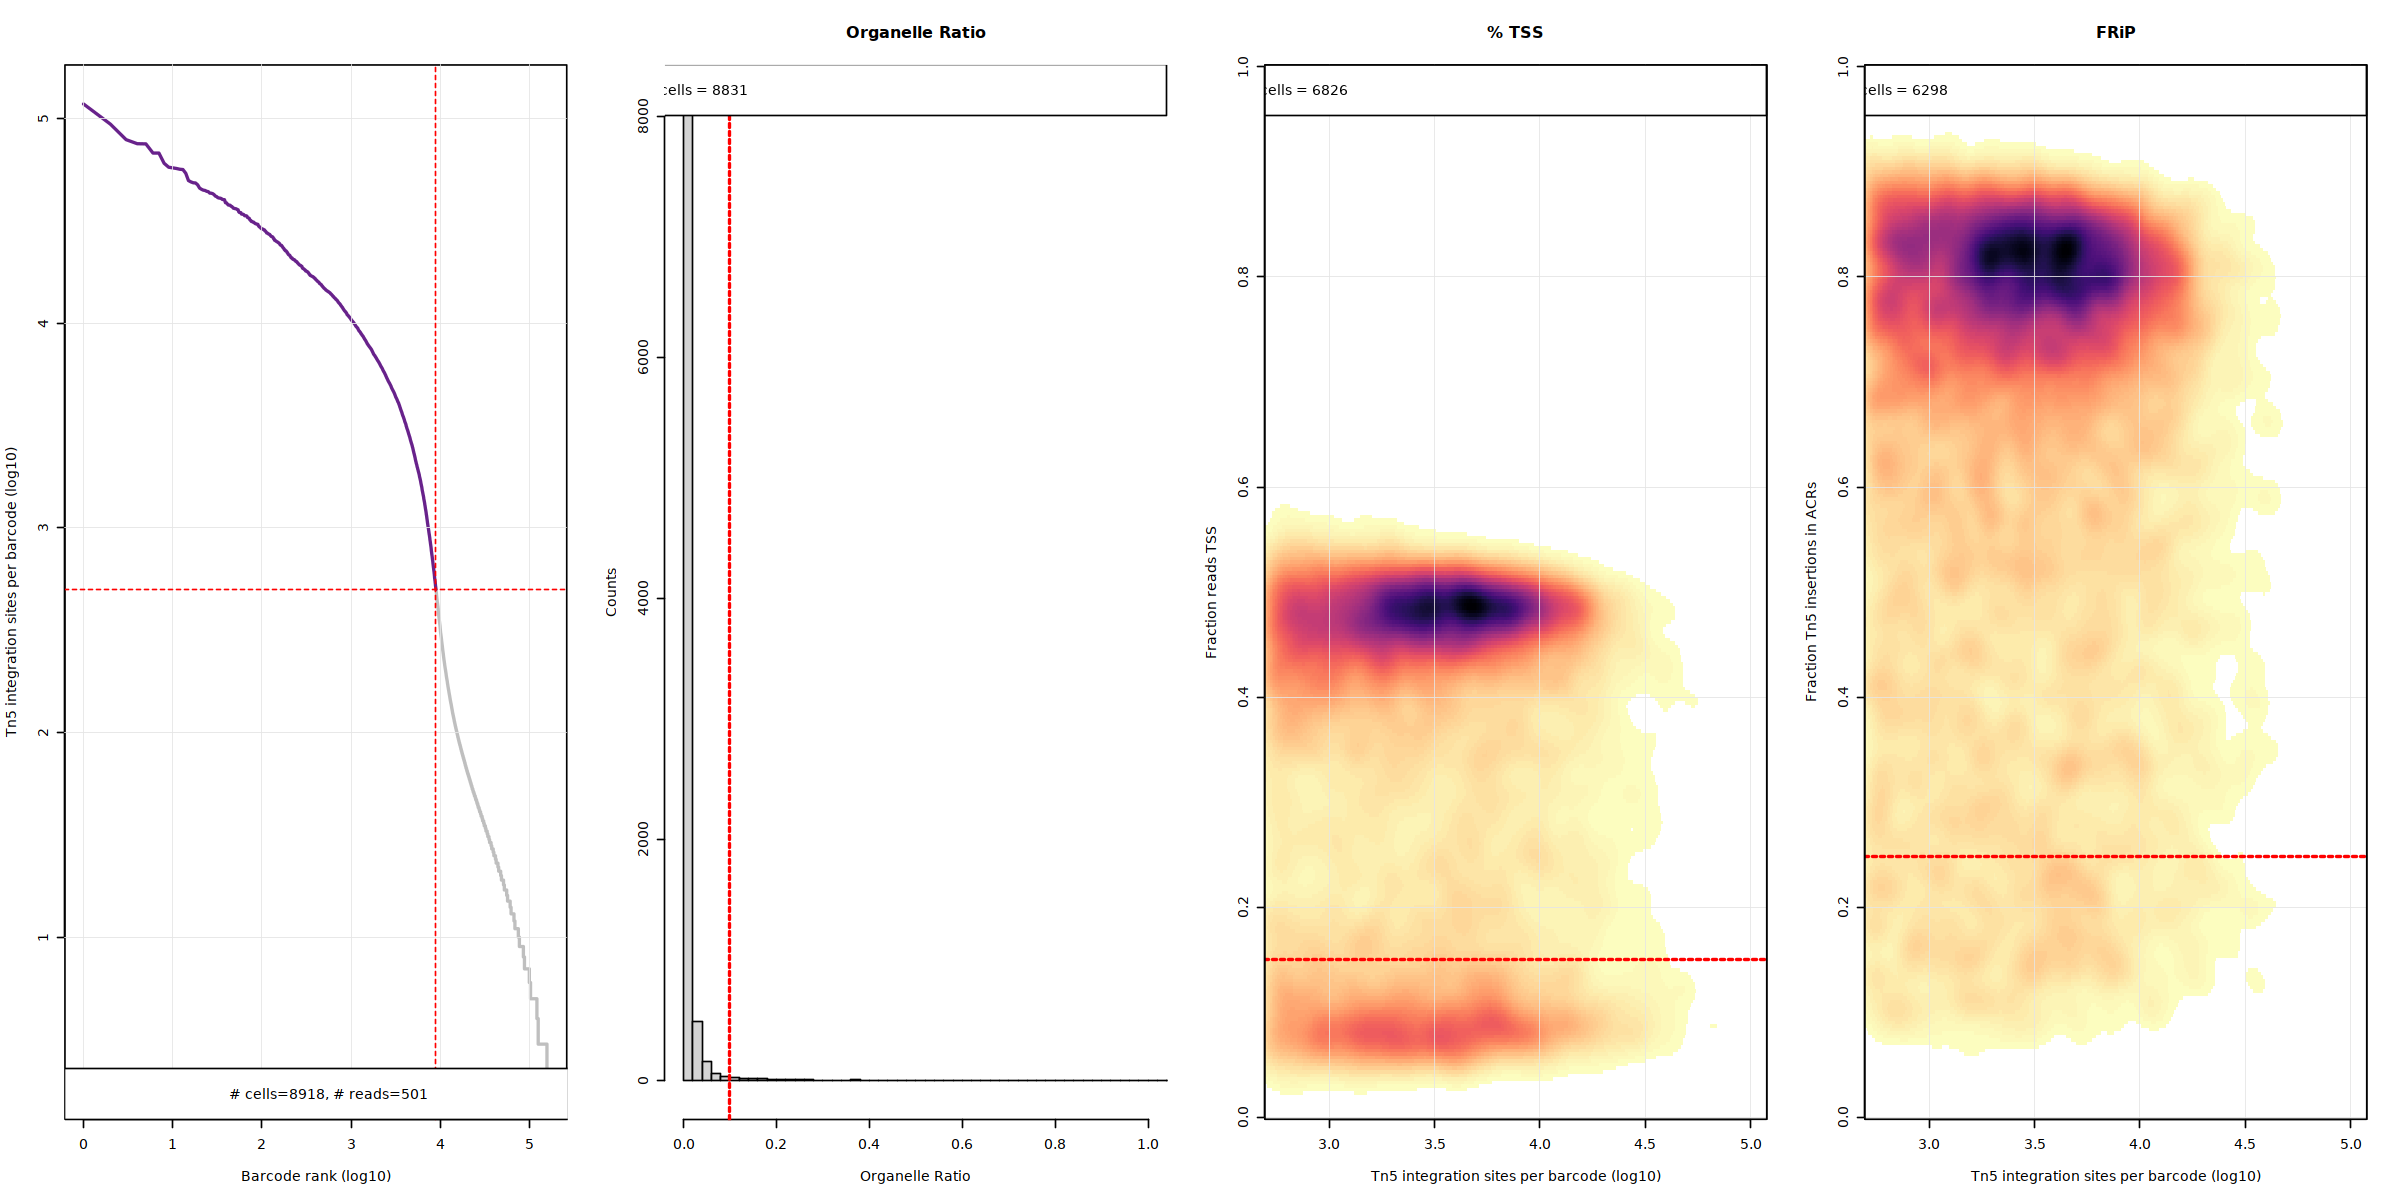

In [5]:
library(repr)
options(repr.plot.width=20, repr.plot.height=10)
zm_leaf_rep_2.meta <- findCells(zm_leaf_rep_2.meta,
                                        doplot=T,
                                        set.tn5.cutoff=500,
                                        max.cells=20000,
                                        min.tn5=500,
                                        filt.tss=TRUE,
                                        filt.frip=TRUE,
                                        #tss.z.thresh=3,
                                        tss.min.freq=.15,
                                        frip.min.freq=0.15,
                                        filt.org = TRUE,
                                        org.filter.thresh=0.1,
                                        prefix=NULL)

In [ ]:
generateMatrix <- function(obj,
                           filtered=T,
                           windows=1000,
                           peaks=FALSE,
                           blacklist=NULL,
                           organelle_scaffolds = NULL,
                           verbose=T){
    

    # convert tn5 bed to Granges
    tn5.gr <- GRanges(seqnames=as.character(obj$bed$V1),
                      ranges=IRanges(start=as.numeric(obj$bed$V2),
                                     end=as.numeric(obj$bed$V3)),
                      strand=as.character(obj$bed$V5),
                      names=as.character(obj$bed$V4))
    
    
    # Remove Organell Scaffolds if given
    if(is.null(organelle_scaffolds) == FALSE) {
        
        tn5.gr <- dropSeqlevels(tn5.gr, organelle_scaffolds)

    } else {
        tn5.gr <- tn5.gr
    }

    
    # Read in baclist if given
    if(is.null(blacklist) == FALSE) {
        blacklist_r <- read.table(as.character(blacklist))

        blacklist.gr <- GRanges(seqnames=as.character(blacklist_r$V1),
                          ranges=IRanges(start=as.numeric(blacklist_r$V2),
                                         end=as.numeric(blacklist_r$V3)),
                          names=as.character(blacklist_r$V4))
    } else {
        blacklist.gr <- NULL
    }

    # use filtered barcodes?
    if(filtered){
        use <- obj$meta.v3
    }else{
        use <- obj$meta
    }


    # generate intervals
    if(!peaks){
        # build bins from specified tile length
        chr.seq.lengths <- as.numeric(obj$chr$V2)
        names(chr.seq.lengths) <- obj$chr$V1
        intervals <- tileGenome(chr.seq.lengths, tilewidth=windows, cut.last.tile.in.chrom=TRUE)

        #Remove if black list included
        #Remove procedure learned from: https://www.biostars.org/p/263214/
        if (is.null(blacklist.gr) == FALSE){

            intervals <- intervals[-queryHits(findOverlaps(intervals, blacklist.gr, type="any")),] 
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")


        }else{
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }


    }else{

        # generate intervals from ACRs
        intervals <- GRanges(seqnames=as.character(obj$acr$V1),
                             ranges=IRanges(start=as.numeric(obj$acr$V2),
                                            end=as.numeric(obj$acr$V3)))

        if (is.null(blacklist.gr) == FALSE){
            intervals <- intervals[-queryHits(findOverlaps(intervals, blacklist.gr, type="any")),] 
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }else{
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }
    }


    # get intervals overlapping Tn5 sites by barcode
    hits <- as.data.frame(findOverlaps(tn5.gr, intervals))
    df <- data.frame(regions=regions[hits$subjectHits], barcodes=as.character(obj$bed$V4)[hits$queryHits])
    df <- df[!duplicated(df),]
    df$binary <- 1
    colnames(df) <- c("V1","V2","V3")
    
    
    #9/26/2022 include for sake of calculation of isCell 
    # make sure nSites is calculated
    #Integration Sites
    a <- df
    
    #Meta data to interset
    b <- use
    a$V1 <- factor(a$V1)
    a$V2 <- factor(a$V2)

    #Generate sparse matrix
    a <- Matrix::sparseMatrix(i=as.numeric(a$V1),
                              j=as.numeric(a$V2),
                              x=as.numeric(a$V3),
                              dimnames=list(levels(a$V1),levels(a$V2)))

    # align barcodes
    both <- intersect(rownames(b), colnames(a))
    a <- a[,both]
    b <- b[both,]

    # make sure nSites is calculated
    b$nSites   <- Matrix::colSums(a)
    b$log10nSites <- log10(b$nSites)

    # return
    obj$counts <- df
    obj$meta <- b 

    
    return(obj)
}

In [6]:
# generate sparse matrix
zm_leaf_rep_2.meta.filtered <- generateMatrix(zm_leaf_rep_2.meta,
                            filtered=FALSE,
                            windows=250,
                            peaks=FALSE,
                            organelle_scaffolds= c("Pt", "Mt"),
                            blacklist = "/home/jpm73279/genome_downloads/Zm-B73-REFERENCE-NAM-5.0/black_list_sc_ATAC/Zm.final_blaclist.final.bed",
                            verbose=T)

#rm(zea_m.Crown_root_1.obj.filtered, zea_m.Crown_root_1.obj.meta, zea_m.Crown_root_1.obj.no_organelle)

In [7]:
zm_leaf_rep_2.meta.filtered <- isCell(zm_leaf_rep_2.meta.filtered,
      num.ref = 1000)

In [9]:
passing_cells <- zm_leaf_rep_2.meta.filtered$meta  %>% 
    dplyr::filter(is_cell == 1)
dim(passing_cells)

zm_leaf_rep_2.meta.filtered$meta.v3 <- passing_cells

[1] 14784    17

In [10]:
colnames(passing_cells)

[1] "cellID"      "total"       "tss"         "acrs"        "ptmt"       
 [6] "nSites"      "log10nSites" "pTSS"        "FRiP"        "pOrg"       
[11] "tss_z"       "acr_z"       "sites_z"     "qc_check"    "background" 
[16] "cellbulk"    "is_cell"

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



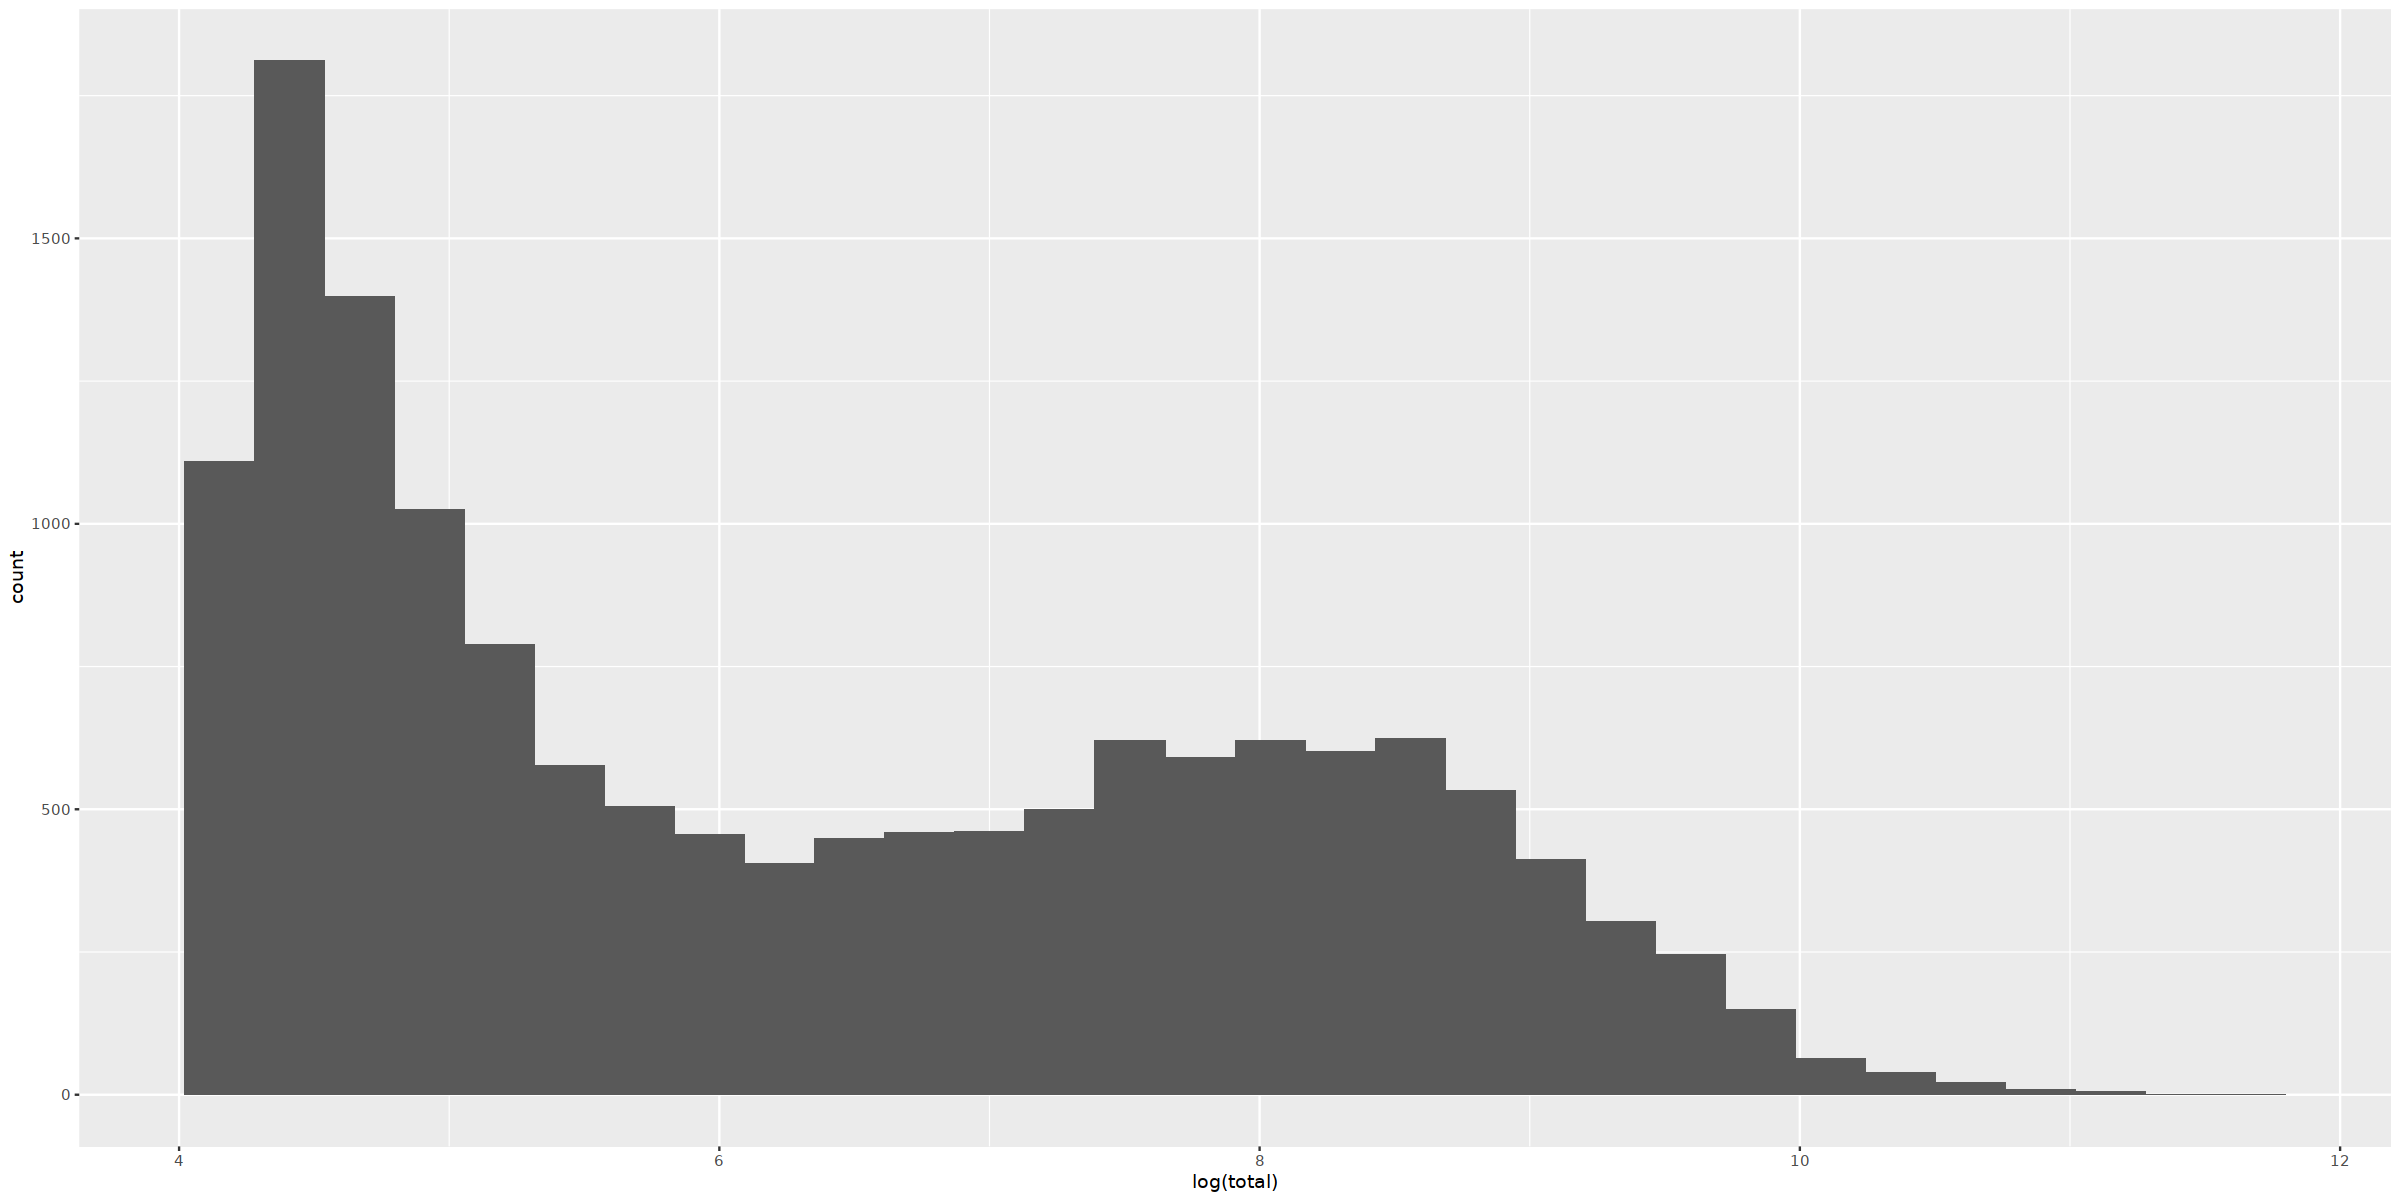

In [11]:
ggplot(passing_cells, aes(log(total))) + geom_histogram()

In [13]:
#pre <- "zm.Leaf_rep1.QC_v2"
# convert to Socrates format for downstream analysis.-
zm_leaf_rep_2.filtered.sparse <- convertSparseData(zm_leaf_rep_2.meta.filtered,
                             verbose=T)


save_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/zea_mays/QC_output/"

 - converting triplet format to sparseMatrix



In [15]:
pre

[1] "zm.Leaf_rep2.QC_v2"

In [14]:
#pre <- "Zea_mays_tis_crown_root_rep_1"
zm.obj.leaf_rep_2.save  <- paste0(save_path,pre, ".rds")
zm.soc.leaf_rep_2.save  <- paste0(save_path,pre, "_soc_obj.rds")

# save QC object
saveRDS(zm_leaf_rep_2.filtered.sparse, file=zm.soc.leaf_rep_2.save)
saveRDS(zm_leaf_rep_2.meta.filtered, file=zm.obj.leaf_rep_2.save)

In [1]:
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_replicate_1 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep1_QC_soc_obj.rds")
sb_replicate_2 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep2_QC_soc_obj.rds")

In [61]:
mean(sb_leaf_rep_2.filtered.sparse$meta$total)

[1] 4576.264

In [62]:
mean(sb_leaf_rep_2.filtered.sparse$meta$tss)

[1] 2612.356

In [66]:
mean(sb_leaf_rep_2.filtered.sparse$meta$acrs)

[1] 3312.324

In [67]:
mean(sb_leaf_rep_2.filtered.sparse$meta$nSites)

[1] 2875.479

In [60]:
dim(sb_leaf_rep_2.meta.filtered$meta)

[1] 181986     17

In [43]:
colnames(sb_leaf_rep_2.filtered.sparse$meta)

[1] "cellID"      "total"       "tss"         "acrs"        "ptmt"       
 [6] "nSites"      "log10nSites" "pTSS"        "FRiP"        "pOrg"       
[11] "tss_z"       "acr_z"       "sites_z"     "qc_check"    "background" 
[16] "cellbulk"    "is_cell"

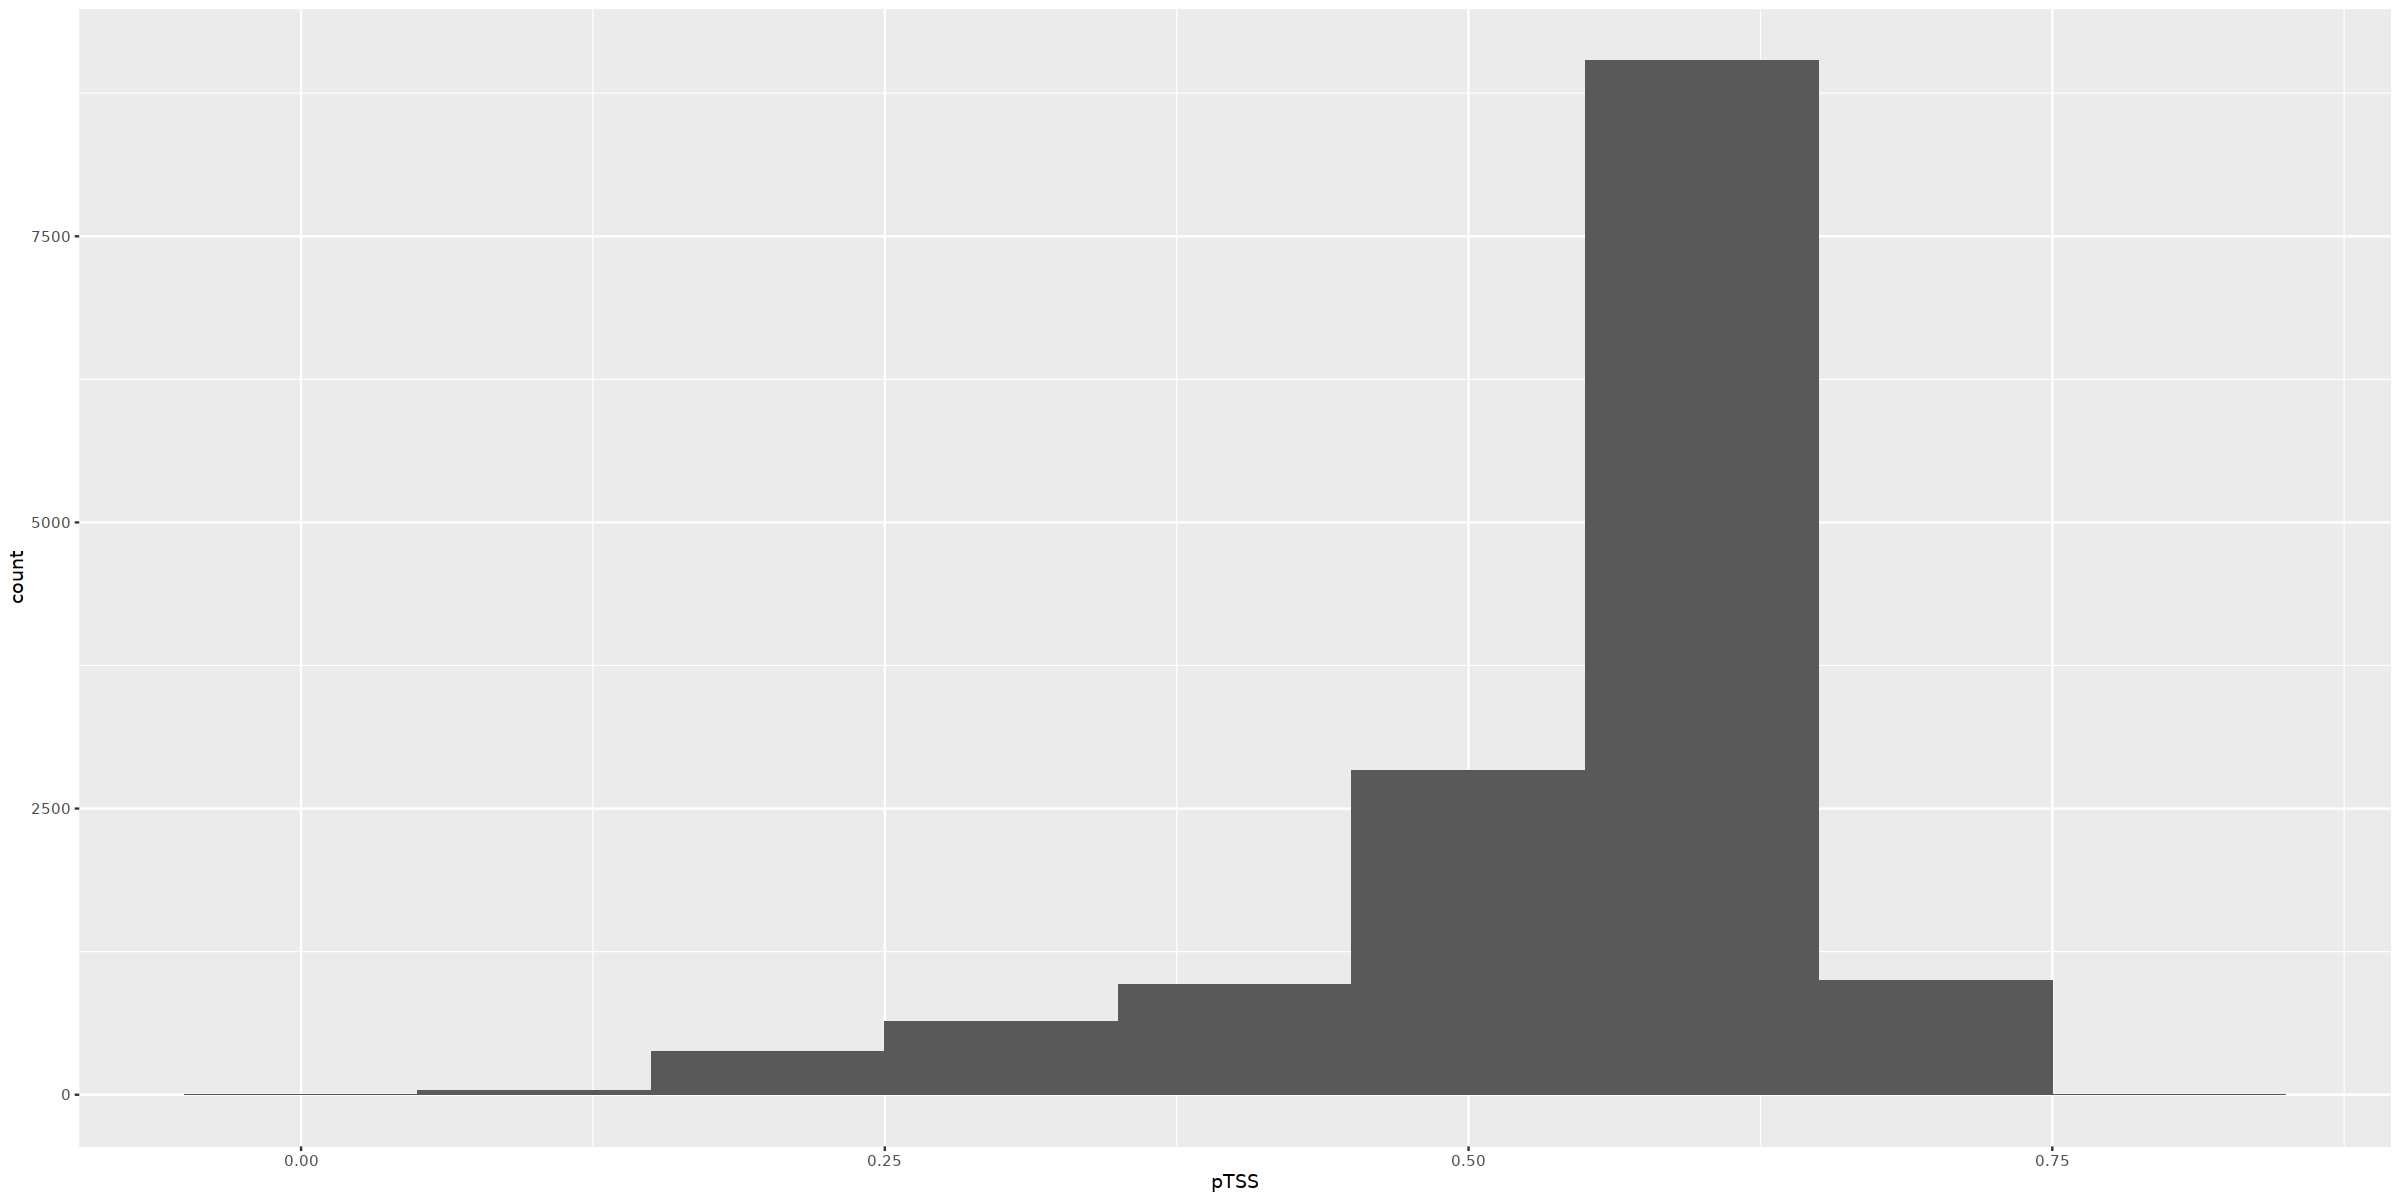

In [79]:
sb_leaf_rep_2.filtered.sparse$meta  %>% 
    dplyr::mutate(prop_ptmt = ptmt/total)  %>% 
    ggplot(., aes(pTSS)) + geom_histogram(binwidth = .1) 
    

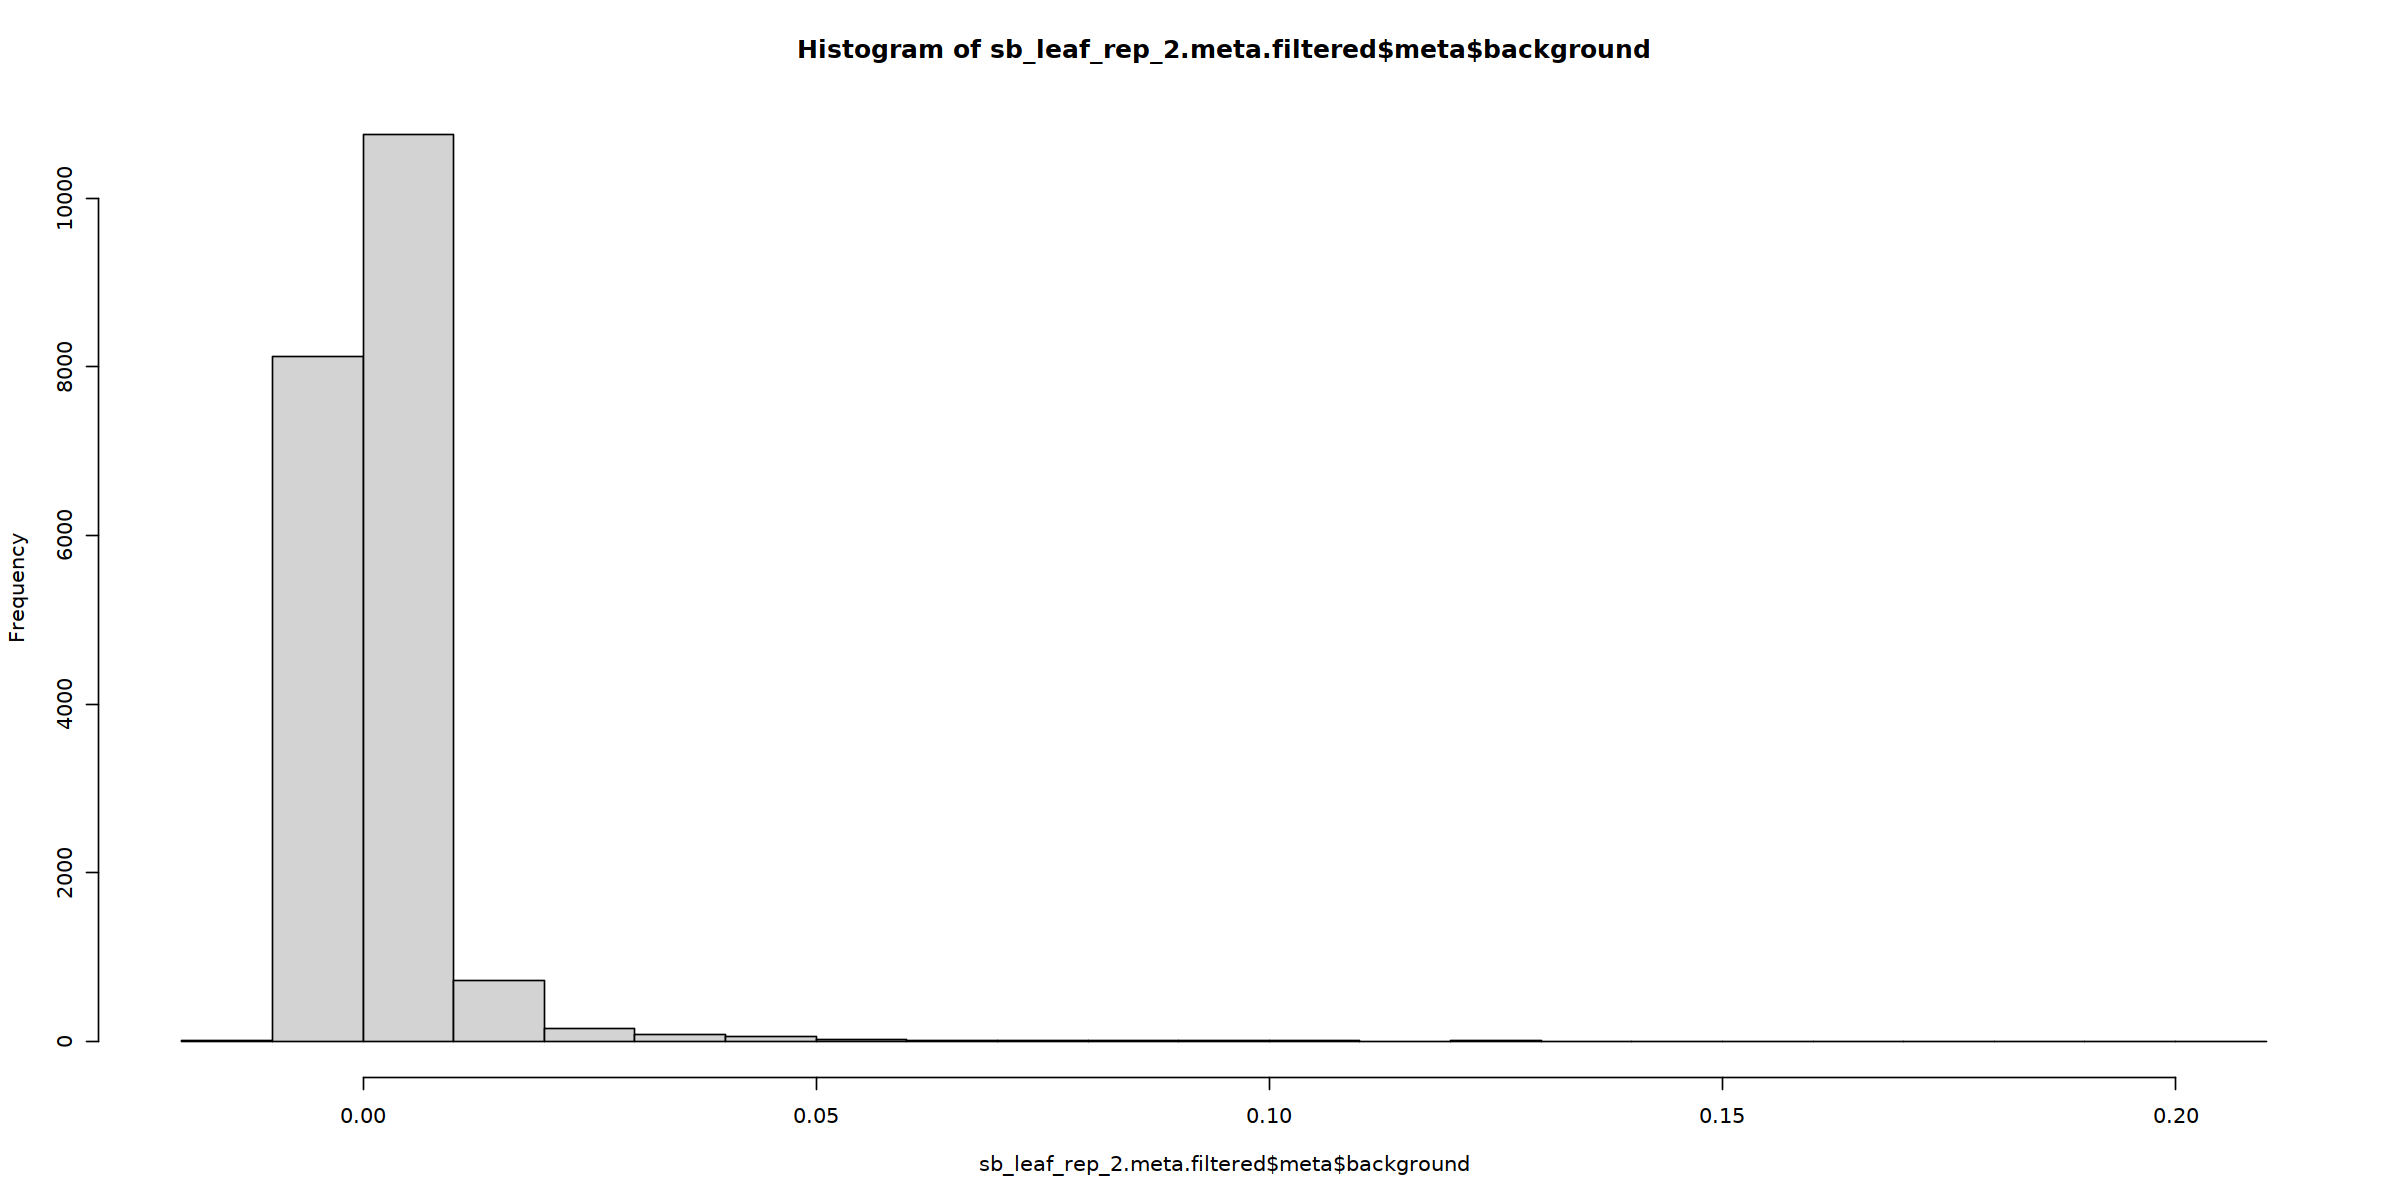

In [75]:
hist(sb_leaf_rep_2.meta.filtered$meta$background)